## Business Objectives

The LiveOps team in SWVL manages the day to day ride monitoring and ride saving activities for all the
markets across the globe. There are agents in the LiveOps team that call captains every day before the ride
with periodic intervals i.e. 60 mins prior, 45 mins prior and 30 mins prior to the ride to ensure that captains are
aware of their next ride(s) and have confirmed the ride on the app so customer have the assurance that they
will be taken to their desired destinations.

This case study aims to identify patterns which indicate - 


        ● Reducing the direct relationship between scalability of business with agent headcount.
        ● Increasing the success rate of calls on T-60, T-45, and T-30 intervals.
        ● Developing strategies to reduce ride cancellations and increase ride confirmations through app i.e.
          Ride_Confirmation_Status to be Captain thru App.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Supress warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',100)

In [4]:
df = pd.read_excel('Live Ops Case Study.xlsx')
df.head(2)

,Ride_ID,Ride_Date,Week_Num,Vertical,Captain_ID,City_Name,Calling Agent,T-60 Mins Call Status,T-45 Mins Call Status,T-30 Mins Call Status,Ride_Confirmation_Status,Ride_Status,Cancellation_Reason
0,Ride No. 1,2021-07-02,27.0,business,Captain 1,Prague,Agent 5,Confirmed,Not Confirmed,Confirmed,Agent,completed,NaN
1,Ride No. 2,2021-07-27,31.0,business,Captain 1,Prague,Agent 8,Not Confirmed,Confirmed,Confirmed,Agent,completed,NaN


In [5]:
df.shape

(30810, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30810 entries, 0 to 30809
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Ride_ID                   30810 non-null  object        
 1   Ride_Date                 30810 non-null  datetime64[ns]
 2   Week_Num                  30810 non-null  float64       
 3   Vertical                  30810 non-null  object        
 4   Captain_ID                30809 non-null  object        
 5   City_Name                 30810 non-null  object        
 6   Calling Agent             30810 non-null  object        
 7   T-60 Mins Call Status     30810 non-null  object        
 8   T-45 Mins Call Status     30810 non-null  object        
 9   T-30 Mins Call Status     30810 non-null  object        
 10  Ride_Confirmation_Status  27744 non-null  object        
 11  Ride_Status               30810 non-null  object        
 12  Cancellation_Reaso

### Handling missing values

In [7]:
'''As ride status is complete , we will impute reason for cancellation with -1'''
df['Cancellation_Reason'].fillna('-1', inplace=True)

In [8]:
df['Ride_Confirmation_Status'].fillna(df['Ride_Confirmation_Status'].mode()[0], inplace=True)

In [9]:
df[df['Captain_ID'].isnull()]
df['Captain_ID'] = df['Captain_ID'].replace(np.nan,'Captain 358')

### Data Pre-Processing

In [10]:
'''Mapping the features'''

df['Week_Num'] = df['Week_Num'].replace({27.0 : '1', 28.0 : '2', 29.0 : '3', 30.0 : '4',
                                         31.0 : '5', 32.0 : '6', 33.0 : '7', 34.0 : '8', 35.0 : '9'})
df['T-60 Mins Call Status'] = df['T-60 Mins Call Status'].map({'Confirmed' : 1, 'Not Confirmed' : 0})
df['T-45 Mins Call Status'] = df['T-45 Mins Call Status'].map({'Confirmed' : 1, 'Not Confirmed' : 0})
df['T-30 Mins Call Status'] = df['T-30 Mins Call Status'].map({'Confirmed' : 1, 'Not Confirmed' : 0})
df['Ride_Status'] = df['Ride_Status'].map({'completed' : 1,'cancelled' : 0})

### Feature Engineering

In [11]:
from datetime import datetime

date_entry = '2021-06-30'
year, month, day = map(int, date_entry.split('-'))
d0 = datetime(year, month, day)
d1 = df['Ride_Date']
delta = d1 - d0
df['Day']= delta
df[["Day"]].head()

,Day
0,2 days
1,27 days
2,56 days
3,6 days
4,17 days


In [12]:
# Cleaning Days 
df['Day'] = df['Day'].astype(str)
df['Day'] = df['Day'].map(lambda x: x[0:2])
df['Day'] = df['Day'].astype(int)

In [13]:
df['Month'] = pd.DatetimeIndex(df['Ride_Date']).month

In [14]:
# Weekdays are taken such that 1 corresponds to Sunday and 7 to Saturday
# Generate the weekday feature
df['Weekday'] = (df['Day']+4)%7
df['Weekday'].replace(0,7, inplace=True)
df['Weekday'] = df['Weekday'].astype(int)

In [15]:
df['Call_status'] = df['T-60 Mins Call Status'] + df['T-45 Mins Call Status'] + df['T-30 Mins Call Status']
df['Call_status'] = df['Call_status'].map(lambda x: 'Yes' if x>1 else 'No')

In [16]:
'''Create a weekend feature'''
def f(x):
    if x==3 or x==4: return '1'
    else: return '0'
    
df['Weekend'] = np.vectorize(f)(df['Weekday'])

df['Weekend'].unique()  #unique values

array(['0', '1'], dtype=object)

### EDA

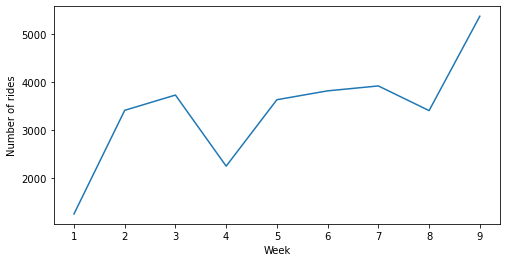

In [17]:
'''Trend analysis'''
x = df['Week_Num'].value_counts()
x.sort_index().plot(figsize=(8, 4))
plt.ylabel('Number of rides')
plt.xlabel('Week')
plt.show()

<b>Inference :</b>

             * The overall trend of goes upwards. Here, we have to take look of the dip at the end of week 4.

In [18]:
'''Week 4- Analysis'''
week4 = df[df['Week_Num'] == '4']
week3 = df[df['Week_Num'] == '3']

w3_reason = week3['Cancellation_Reason'].value_counts()
w4_reason = week4['Cancellation_Reason'].value_counts()
display(w3_reason,w4_reason)

-1                         3292
planning_issue              152
leave_excuse                108
captain_churned             101
low_utilized_rides           20
dispatchment_issue           17
terminated                   12
absence                      11
inride_issue                 10
internet_unavailability       3
payment_issue                 2
unprofessional_attitude       1
transfer_only                 1
saving_important_ride         1
Name: Cancellation_Reason, dtype: int64

-1                         1575
low_utilized_rides          322
planning_issue              292
leave_excuse                 33
dispatchment_issue           13
absence                      12
accident                      4
internet_unavailability       2
inride_issue                  2
Name: Cancellation_Reason, dtype: int64

 Reason for cancellation 


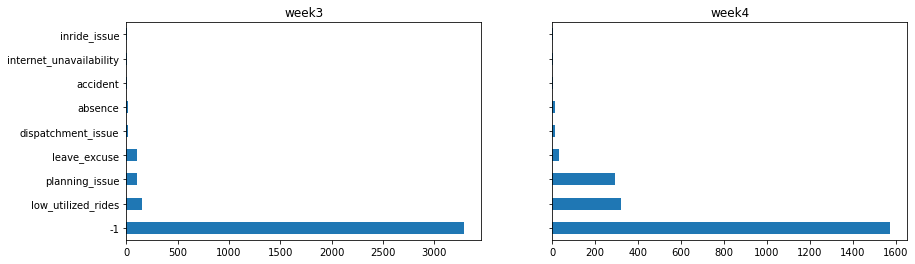

In [19]:
print(' Reason for cancellation ')
fig, (ax1, ax2) = plt.subplots(figsize=[14,4], ncols=2, sharey=True)
w3_reason.plot(kind='barh', ax=ax1)
ax1.title.set_text('week3')
w4_reason.plot(kind='barh', ax=ax2)
ax2.title.set_text('week4')
plt.show()

<b>Inference : </b>

             * We can see that, total number of successful rides are reduced by 50%
             * The low utilization rides are much greater.
             * We conclude cause of dip may be due to an environmental issues(i.e COVID19 lockdown) or festival week.

business    1891
regular     1755
travel        85
Name: Vertical, dtype: int64

business    1703
regular      502
travel        50
Name: Vertical, dtype: int64

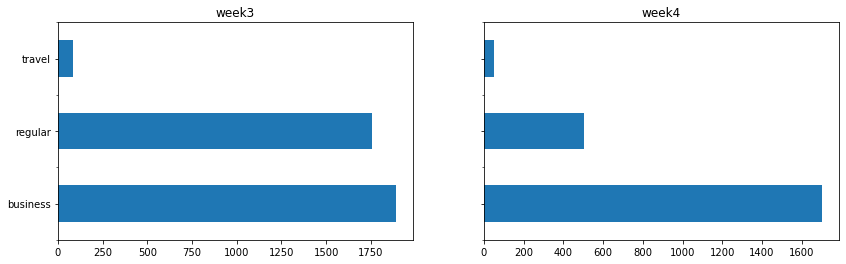

In [20]:
'''Analyse week3 and week4 based on type of customers'''
w3_occupation = week3['Vertical'].value_counts()
w4_occupation = week4['Vertical'].value_counts()

display(w3_occupation, w4_occupation)
fig, (ax1, ax2) = plt.subplots(figsize=[14,4], ncols=2, sharey=True)
w3_occupation.plot(kind='barh', ax=ax1)
ax1.title.set_text('week3')
w4_occupation.plot(kind='barh', ax=ax2)
ax2.title.set_text('week4')
plt.show()

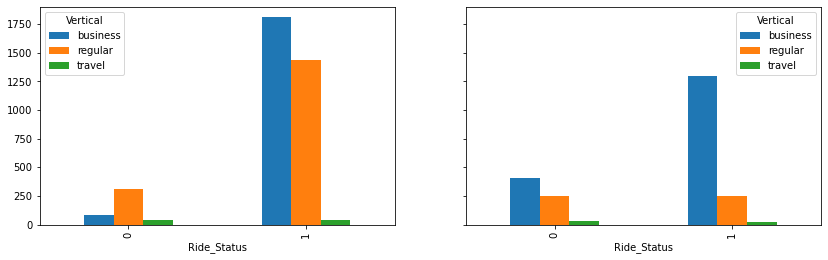

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize=[14,4], ncols=2, sharey=True)
ax1 = pd.crosstab(week3['Ride_Status'], week3['Vertical']).plot(kind='bar', stacked=False, ax=ax1)
ax2 = pd.crosstab(week4['Ride_Status'], week4['Vertical']).plot(kind='bar', stacked=False, ax=ax2)
plt.show()

Now we have to analyse the reason behind ride cancellation with good call success rate. As this would help company to overcome the revenue dip.

In [22]:
'''Percentage of ride cancellation through agent/captain thru app for successful call status in period of 30, 45, 60mins'''
df_new = df[['Ride_Confirmation_Status','Cancellation_Reason']] [(df['Ride_Status']==0) & (df['Call_status']=='Yes')].value_counts(normalize=True)*100
df_new.sort_index()

Ride_Confirmation_Status  Cancellation_Reason    
Agent                     Captain_churned             1.591512
                          absence                     2.766199
                          accident                    0.227359
                          captain_churned            10.837438
                          captain_was_late            0.037893
                          dispatchment_issue          4.812429
                          inride_issue                1.553619
                          internet_unavailability     0.719970
                          lack_diligence              0.037893
                          leave_excuse               13.262599
                          lost_stolen_mobile          0.037893
                          low_utilized_rides         19.325502
                          payment_issue               0.227359
                          planning_issue             42.288746
                          police_issue                0.113679
     

<b>Inference : </b>

             * Information regarding captain's churn would be helpful make an alternative decision and lead to increase in
               successful ride by 2%
             * As planning issue is one of the main reason. So, imposing a minimum fine during next ride.
             * Vehicle maintainance need to be supervised regularly.

From Business point of view, it's necessary to check the performance of our captains/drivers and calling agent.
Hence, this will be helpful in formulating the feedback.

In [23]:
'''Number of completed and cancelled rides by captains'''
Ride_completed = df[df['Ride_Status']==1].groupby(by=['Captain_ID'])[['Ride_Status']].count().T
Ride_cancelled = df[df['Ride_Status']==0].groupby(by=['Captain_ID'])[['Ride_Status']].count().T

captains = list(df['Captain_ID'].unique())
print(f'There are {len(captains)} unique captains.')

display(Ride_completed.head(), Ride_cancelled.head())

There are 358 unique captains.


Captain_ID,Captain 1,Captain 10,Captain 100,Captain 101,Captain 102,Captain 103,Captain 104,Captain 105,Captain 106,Captain 107,Captain 108,Captain 109,Captain 11,Captain 110,Captain 111,Captain 112,Captain 113,Captain 114,Captain 115,Captain 116,Captain 117,Captain 118,Captain 119,Captain 12,Captain 120,Captain 121,Captain 122,Captain 123,Captain 124,Captain 125,Captain 126,Captain 127,Captain 128,Captain 129,Captain 13,Captain 130,Captain 131,Captain 132,Captain 133,Captain 134,Captain 135,Captain 136,Captain 137,Captain 138,Captain 139,Captain 14,Captain 140,Captain 141,Captain 142,Captain 143,...,Captain 54,Captain 55,Captain 56,Captain 57,Captain 58,Captain 59,Captain 6,Captain 60,Captain 61,Captain 62,Captain 63,Captain 64,Captain 65,Captain 66,Captain 67,Captain 68,Captain 69,Captain 7,Captain 70,Captain 71,Captain 72,Captain 73,Captain 74,Captain 75,Captain 76,Captain 77,Captain 78,Captain 79,Captain 8,Captain 80,Captain 81,Captain 82,Captain 83,Captain 84,Captain 85,Captain 86,Captain 87,Captain 88,Captain 89,Captain 9,Captain 90,Captain 91,Captain 92,Captain 93,Captain 94,Captain 95,Captain 96,Captain 97,Captain 98,Captain 99
Ride_Status,125,281,409,234,57,57,46,143,52,54,175,34,195,38,11,48,28,30,14,90,399,50,180,162,51,55,53,54,52,119,8,169,84,21,146,132,142,44,119,136,97,132,31,34,115,211,128,74,140,108,...,17,173,189,7,131,94,381,98,99,11,128,152,86,166,15,75,111,232,31,43,44,42,152,231,173,273,88,54,19,88,71,67,74,39,39,33,90,52,38,348,220,90,89,184,344,209,333,274,55,201


Captain_ID,Captain 1,Captain 10,Captain 100,Captain 101,Captain 104,Captain 105,Captain 107,Captain 108,Captain 11,Captain 110,Captain 111,Captain 112,Captain 113,Captain 114,Captain 116,Captain 117,Captain 118,Captain 119,Captain 12,Captain 120,Captain 122,Captain 125,Captain 127,Captain 128,Captain 129,Captain 13,Captain 130,Captain 131,Captain 132,Captain 133,Captain 134,Captain 135,Captain 136,Captain 137,Captain 138,Captain 139,Captain 14,Captain 140,Captain 142,Captain 143,Captain 144,Captain 145,Captain 146,Captain 147,Captain 148,Captain 15,Captain 150,Captain 151,Captain 153,Captain 154,...,Captain 50,Captain 51,Captain 52,Captain 53,Captain 55,Captain 56,Captain 58,Captain 59,Captain 6,Captain 60,Captain 61,Captain 62,Captain 63,Captain 64,Captain 65,Captain 66,Captain 68,Captain 69,Captain 7,Captain 70,Captain 71,Captain 72,Captain 73,Captain 74,Captain 75,Captain 76,Captain 77,Captain 78,Captain 79,Captain 80,Captain 81,Captain 82,Captain 83,Captain 84,Captain 85,Captain 86,Captain 87,Captain 88,Captain 89,Captain 9,Captain 90,Captain 91,Captain 92,Captain 93,Captain 94,Captain 95,Captain 96,Captain 97,Captain 98,Captain 99
Ride_Status,3,3,24,28,4,11,1,6,7,16,18,12,4,7,14,10,5,11,4,3,1,20,70,25,6,25,13,5,3,12,10,13,13,4,17,4,22,16,4,31,2,8,2,14,19,1,5,2,13,2,...,9,11,4,11,21,18,3,5,10,2,11,31,6,24,8,37,5,22,5,22,10,9,11,12,45,35,55,12,6,12,16,2,12,7,7,6,8,8,16,3,46,17,8,14,6,27,2,16,3,5


In [24]:
x = pd.concat([Ride_completed, Ride_cancelled]).T
x.columns = ['completed_ride', 'cancelled_ride']
x = x.replace(np.nan, 0)  # Null-value indicate that the captain with zero cancelled/completed rides.

NetRides = x['completed_ride'] - x['cancelled_ride']
TotalRides = x['completed_ride'] + x['cancelled_ride']
Captain_value = pd.concat([NetRides,TotalRides], axis=1)
Captain_value = Captain_value.rename(columns={0:'NetRides', 1:'TotalRides'}).sort_values(by='TotalRides')
Captain_value.head()

,NetRides,TotalRides
Captain_ID,,
Captain 358,-1.0,1.0
Captain 352,-1.0,1.0
Captain 356,1.0,1.0
Captain 317,-1.0,1.0
Captain 355,1.0,1.0


In [25]:
'''Sucessful captains - They are the one who makes good revenue to our company.'''
# print('Top 30 Captains -')
# display(Captain_value.head(30).T)

print('Captains are -')
Captain_value.head(30).index.to_list()

Captains are -


['Captain 358',
 'Captain 352',
 'Captain 356',
 'Captain 317',
 'Captain 355',
 'Captain 350',
 'Captain 334',
 'Captain 357',
 'Captain 345',
 'Captain 298',
 'Captain 339',
 'Captain 349',
 'Captain 354',
 'Captain 342',
 'Captain 353',
 'Captain 340',
 'Captain 173',
 'Captain 288',
 'Captain 236',
 'Captain 327',
 'Captain 344',
 'Captain 335',
 'Captain 347',
 'Captain 329',
 'Captain 326',
 'Captain 57',
 'Captain 126',
 'Captain 325',
 'Captain 312',
 'Captain 303']

In [26]:
'''Need to note on Caption's behaviour in near future 
   Output, negative sign denotes that Captain"s cancelled ride was more than sucessful ride. We need to 
   make a  note of those captain"s value/behaviour in near future. Excluding new join/whose total rides is less than 10.'''
x = Captain_value[(Captain_value['NetRides']<=0) & (Captain_value['TotalRides']>=10)]
print('No. of such captains =',x.shape[0])
print('Captains are -')
x.index.to_list()

No. of such captains = 35
Captains are -


['Captain 330',
 'Captain 351',
 'Captain 259',
 'Captain 299',
 'Captain 324',
 'Captain 250',
 'Captain 304',
 'Captain 249',
 'Captain 318',
 'Captain 346',
 'Captain 248',
 'Captain 319',
 'Captain 258',
 'Captain 254',
 'Captain 261',
 'Captain 301',
 'Captain 297',
 'Captain 255',
 'Captain 300',
 'Captain 244',
 'Captain 296',
 'Captain 307',
 'Captain 256',
 'Captain 337',
 'Captain 287',
 'Captain 111',
 'Captain 320',
 'Captain 62',
 'Captain 190',
 'Captain 206',
 'Captain 228',
 'Captain 225',
 'Captain 260',
 'Captain 257',
 'Captain 247']

In [27]:
'''Potential Agent - The one who makes most successfull ride status'''
def Potential_agent(week):
        success_ride = df[df['Ride_Status'] == 1]
        Top3 = success_ride[success_ride['Week_Num'] == week].groupby(by='Calling Agent')['Ride_Status'].count()
        Top3.sort_values(ascending=False, inplace=True)
        
        Top3_agent =  Top3.head(3).index.to_list()   #list of top3 agents
        Top3_ride = Top3.head(3).values              #list of total rides of top3 agents
        return dict(zip(Top3_agent,Top3_ride))

In [28]:
weeks = list(df['Week_Num'].unique())
agents = [Potential_agent(w) for w in weeks]
potential_agents = dict(zip(weeks, agents))
potential_agents = [{'week'+key : value} for (key, value) in sorted(potential_agents.items(), key=lambda x: x[0])] #sort

In [29]:
potential_agents  #9 weeks record

[{'week1': {'Agent 1': 236, 'Agent 3': 226, 'Agent 2': 225}},
 {'week2': {'Agent 4': 610, 'Agent 5': 610, 'Agent 1': 585}},
 {'week3': {'Agent 3': 620, 'Agent 5': 601, 'Agent 4': 595}},
 {'week4': {'Agent 2': 308, 'Agent 5': 293, 'Agent 1': 289}},
 {'week5': {'Agent 7': 519, 'Agent 6': 510, 'Agent 5': 492}},
 {'week6': {'Agent 7': 502, 'Agent 5': 497, 'Agent 8': 483}},
 {'week7': {'Agent 7': 551, 'Agent 8': 546, 'Agent 5': 545}},
 {'week8': {'Agent 7': 320, 'Agent 3': 319, 'Agent 2': 309}},
 {'week9': {'Agent 2': 529, 'Agent 4': 513, 'Agent 8': 513}}]

In [30]:
'''Percentage of customers using App/Agent for booking across various customers across the globe'''

(df[['Ride_Confirmation_Status', 'Vertical']].value_counts(normalize=True)*100).sort_index()

Ride_Confirmation_Status  Vertical
Agent                     business    36.062967
                          regular     43.206751
                          training     0.022720
                          travel       1.428108
Captain thru App          business    18.104512
                          custom       0.006491
                          regular      0.334307
                          training     0.003246
                          travel       0.830899
dtype: float64

<b>Inference:</b>

            * Nearly 45% "Regular" and 36% "Business" type customers using our service. 
              We should make them aware of Captain app to the customers.

In [31]:
def Percent(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

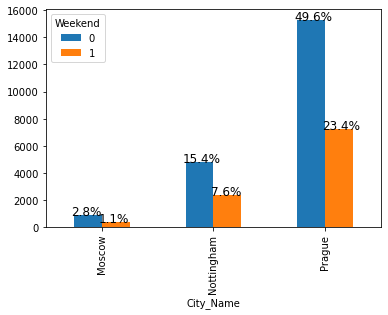

In [32]:
'''Ride status across various cities'''
ax = pd.crosstab(df['City_Name'], df['Weekend']).plot(kind='bar')
Percent(ax,df['City_Name'])
plt.show()

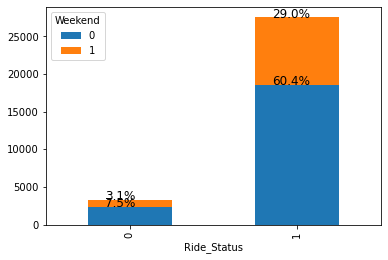

In [33]:
'''Ride status in weekend'''
ax = pd.crosstab(df['Ride_Status'], df['Weekend']).plot(kind='bar', stacked = True)
Percent(ax,df['City_Name'])
plt.show()

<b>Inference : </b>
    
            * Business Professtional from Nottingham contribute a decent revenue.
            * In weekends the dip in rides is about 45-50% in comparison to weekdays.
            * In nutshell we can conclude that rides during weekdays(except: Tuesday & Wednesday) are high.